# STAT 790 : SINDy Project

## Python Libararies, etc


In [1]:
pip install pysindy

### incomplete log of attempt to suppress sparsity error


In [2]:
#!/usr/bin/env python -W ignore::UserWarning


In [3]:
# pysindy.optimizers.stlsq.py throws tons of useless userwarnings
# rectification should happen first, but nothing works!!
# tried numerous wrappers, warnings, etc # mostly right at error() def

'''
import warnings
with warnings.catch_warnings():
  warnings.filterwarnings("ignore") #,category=UserWarning)
  #import pysindy as ps

import warnings

def suppress_warnings(func):
  """Decorator to suppress warnings during function execution."""
  @wraps(func)
  def wrapper(*args, **kwargs):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")  # Ignore all warnings within the function
      return func(*args, **kwargs)
  return wrapper
'''


'\nimport warnings\nwith warnings.catch_warnings():\n  warnings.filterwarnings("ignore") #,category=UserWarning)\n  #import pysindy as ps\n\nimport warnings\n\ndef suppress_warnings(func):\n  """Decorator to suppress warnings during function execution."""\n  @wraps(func)\n  def wrapper(*args, **kwargs):\n    with warnings.catch_warnings():\n      warnings.simplefilter("ignore")  # Ignore all warnings within the function\n      return func(*args, **kwargs)\n  return wrapper\n'

### necessary libraries


In [1]:
# Packages needed to import

# data  methods
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import griddata
from scipy.io import loadmat

# output methods
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sbn
from tabulate import tabulate

# pysindy
import pysindy as ps
#ps.VERBOSE = 0 # doesnt work # no matter where located # here for completeness
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz

### settings

#np.random.seed(1000)  # Seed for reproducibility # meaningless here bc pysindy?

# Integrator keywords for sciypy.integrate.solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


## Initial Condition


0 [6.53589585 1.15006943]
1 [9.50282864 4.82191401]
2 [8.72474535 2.12332681]
3 [0.40709625 3.97194461]
4 [2.33132197 8.41740724]
5 [2.07082344 7.42469534]
6 [3.92154128 1.8225652 ]
7 [7.43539415 0.69582081]
8 [8.85337204 9.52644399]
9 [9.31143435 4.15430953]
10 [0.28981659 9.82027485]
11 [3.39637684 7.06687194]
12 [3.61877068 0.35105898]
13 [8.55058253 6.57253508]
14 [7.65682994 5.54087238]
15 [8.85092937 9.04197615]
16 [0.10421701 0.74556736]
17 [2.4462921  1.33304752]
18 [6.979251   3.98204884]
19 [8.83122191 1.8100751 ]
20 [4.32499172 0.18143203]
21 [6.91437862 4.69690652]
22 [1.2822219  8.91337051]
23 [9.18203624 0.73120994]
24 [0.45447943 4.38572896]
25 [6.0172093  3.10227034]
26 [6.81908242 2.09013151]
27 [5.19604297 5.65988831]
28 [4.41167393 1.37556157]
29 [2.13543191 1.33371892]
30 [3.22296701 2.33887115]
31 [5.27498156 5.65971162]
32 [4.38225285 3.21872624]
33 [5.59640811 8.65345581]
34 [8.47282877 1.07817166]
35 [3.16319484 4.09478659]
36 [6.87089014 7.02235287]
37 [4.46197

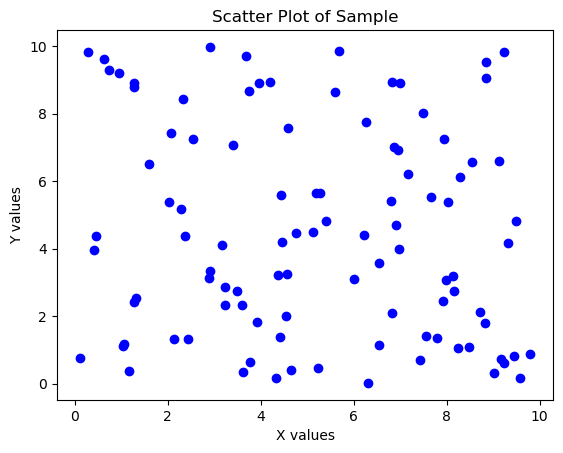

In [2]:
# Generating a sample of points from a Uniform Distribution

import random # get rid of this one in favor of numpy.random

sample_size =  100
observation_size = 2

sampleofICs = []

if False:
  for i in range(sample_size):
      observation = [random.uniform(0, 10) for i in range(observation_size)]
      sampleofICs.append(observation)

else:
  # Use numpy.random.uniform to generate random samples
  np.random.seed(1000) # needs to happen here if repeatable # bc pysindy?
  for i in range(sample_size):
      observation = np.random.uniform(low=0.0, high=10.0, size=observation_size)
      print(i,observation)
      sampleofICs.append(observation.tolist())

# Shows all sample of random points drawn from a Uniform Distribution
# print(sampleofICs)

# Extract X and Y values from sample

x_values = [obs[0] for obs in sampleofICs]
y_values = [obs[1] for obs in sampleofICs]

# print("X values:", x_values)
# print("Y values:", y_values)

# Plotting the sample of random points on a Cartesian plane

plt.plot(x_values, y_values, 'bo')  # Plot x and y values
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Scatter Plot of Sample')
plt.show()

## Defining Error Function


In [3]:
# Function that calculates the error

def error_function(initial_condition,threshold):

    #def linear_SHO_general(a_11,a_12,a_21,a_22):
        #return [a_11 * x[0] + a_12 * x[1], a_21 * x[0] + a_22 * x[1]]

    #print(linear_SHO_general(1,2,3,4))
    
    #def linear_SHO(t, x):
        #return linear_SHO_general(a_11,a_12,a_21,a_22)
        #linear_SHO_general(a_11,a_12,a_21,a_22)
        #return [a_11 * x[0] + a_12 * x[1], a_21 * x[0] + a_22 * x[1]]

    #linear_SHO
    
    dt = 0.01
    t_train = np.arange(0, 25, dt)
    t_train_span = (t_train[0], t_train[-1])
    x0_train = initial_condition
    x_train = solve_ivp(linear_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

    poly_order = 4

    model = ps.SINDy(
        optimizer=ps.SR3(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    # Fit SINDy model to data
    model.fit(x_train, t=dt)

    # Coefficients of the model
    # a_11 = -0.1
    # a_12 = 2.0
    # a_21 = -2.0
    # a_22 = -0.1

    # Coefficients of the model
    a_11 = 1.0
    a_12 = -10
    a_21 = 5.0
    a_22 = 6.0

    
    # Relabeling the coefficients of the SINDy model
    b_11 = model.coefficients()[0,1]
    b_12 = model.coefficients()[0,2]
    b_21 = model.coefficients()[1,1]
    b_22 = model.coefficients()[1,2]

    # Computing the differences
    c_11 = a_11 - b_11
    c_12 = a_12 - b_12
    c_21 = a_12 - b_21
    c_22 = a_22 - b_22

    # Error Vector
    error_vector = np.array([c_11,c_12,c_21,c_22])

    # Compute error between matrices a and b
    # error = np.abs(a_11 - b_11) + np.abs(a_12 - b_12) + np.abs(a_21 - b_21) + np.abs(a_22 - b_22) # L1 norm
    # error = np.linalg.norm(error_vector) # L2 norm
    error = pow(a_11 - b_11,2) + pow(a_12 - b_12,2) + pow(a_21 - b_21,2) + pow(a_22 - b_22,2) # SE
    error = error/4 # MSE

    # error = int(error*1000)/1000. # ugly

    return error


In [ ]:
error_function([0.2790974374874622, 8.974304515389814],1.0)

Traceback (most recent call last):
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
  File "/Users/edgarrr.cd/anaconda3/envs/homl3/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    return self.fun_single(t, y)
  File "/Users/edgarrr.cd/anaconda3/envs/homl3/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
TypeError: error_function.<locals>.linear_SHO() missing 4 required positional arguments: 'a_21', 'a_22', 't', and 'x'


## Finding the thresholds

###### one algorithm that calls functions a or b


The code is the same except for how $h_{i+1}$ depends on $h_i,h_{i-1}$. That logic put in functions and which function selected depending on which problem to solve.

In [25]:
# problem a: smallest threshold ≤ max error # version one
# problem b: largest threshold giving best error

z = lambda x,threshold,max_error: abs(error_function(x,threshold) - max_error)

def next_threshold_problemA(step,error,h0,h1):
  # index 0 ~ iteration 1
  if step==0:
    if error==0:
      h_new = h0/2
    else:
      h_new = 2*h0

  else: # index i ~ n : anything after that
    if error==0:
      h_new = (h1+h0)/2.
    else:
      h_new = 2*h1
  return h_new

def next_threshold_problemB(step,error,h0,h1):
  # index 0 ~ iteration 1
  if step==0:
    if error==0:
      h_new = 2*h0
    else:
      h_new = h0/2

  else: # index i ~ n : anything after that
    if error==0:
      h_new = 2*h1
    else:
      h_new = (h1+h0)/2.
  return h_new

# configure which run / add new runs here
if False:
  # case A-00 ~ everything became h = 2.6
  h_initial = .1 # intial threshold
  i_zeros_max = 3 # maximum number of zeros
  b_dynamic_h = False
  next_threshold = next_threshold_problemA
  max_error = 4.199
  s_problem = f"Problem A, Max Zeros = {i_zeros_max}, $h_0$ = {h_initial}{', Dynamic' if b_dynamic_h else ''}"
elif False:
  # case A-01 ~ every x has same h_initial
  h_initial = 2.95 # intial threshold # tried 2.6 (output from case 00); tried 2.95 (from case 01)
  i_zeros_max = 3 # maximum number of zeros
  b_dynamic_h = False
  next_threshold = next_threshold_problemA
  max_error = 4.199
  s_problem = f"Problem A, Max Zeros = {i_zeros_max}, $h_0$ = {h_initial}{', Dynamic' if b_dynamic_h else ''}"
elif False:
  # case A-02 ~ every x[i+1] has h_initial = final h[i] from previous x[i]
  h_initial = max_error # intial threshold # tried 2.6 (output from case 00); tried 2.95 (from case 01)
  i_zeros_max = 3 # maximum number of zeros
  b_dynamic_h = True
  next_threshold = next_threshold_problemA
  max_error = 4.199
  s_problem = f"Problem A, Max Zeros = {i_zeros_max}, $h_0$ = {h_initial}{', Dynamic' if b_dynamic_h else ''}"
elif False:
  # case B-00 ~ everything became h = 0.0008
  h_initial = .0001 # intial threshold
  i_zeros_max = 3 # maximum number of zeros
  b_dynamic_h = False
  next_threshold = next_threshold_problemB
  max_error = 0
  s_problem = f"Problem B, Max Zeros = {i_zeros_max}, $h_0$ = {h_initial}{', Dynamic' if b_dynamic_h else ''}"
elif False:
  # case B-01 ~ every x has same h_initial 0.0008 (output from case 00); tried 0.0064 (from case 01)
  h_initial = .0128 # intial threshold # using third attempt at h_initial
  i_zeros_max = 3 # maximum number of zeros
  b_dynamic_h = False
  next_threshold = next_threshold_problemB
  max_error = 0
  s_problem = f"Problem B, Max Zeros = {i_zeros_max}, $h_0$ = {h_initial}{', Dynamic' if b_dynamic_h else ''}"
else: # where new x h_initial is successful hi from previous x
  # case B-02 ~ every x[i+1] has h_initial = final h[i] from previous x[i]
  h_initial = .01 # intial threshold # tried 0.0008 (output from case 00); tried 0.0064 (from case 01)
  i_zeros_max = 3 # maximum number of zeros
  b_dynamic_h = True
  next_threshold = next_threshold_problemB
  max_error = 0
  s_problem = f"Problem B, Max Zeros = {i_zeros_max}, $h_0$ = {h_initial}{', Dynamic' if b_dynamic_h else ''}"

i_h_max = 10
data = [] # saves threshold per (x,y) in sampleofICs

for x in sampleofICs: # "initial condition" ~ entire sample of data
  i_zeros = 0
  i_steps = 0 # total number of iterations to get zeros
  h0 = hi = h_save = h_initial
  zi = z(x,hi,max_error)

  i_h = 0 # while-loop iterations before reset with different h_initial conditions
  while (zi >= 0) and (i_h < i_h_max): # per h ~ threshold size
    if zi == 0:
      i_zeros += 1
      h_save = hi

    h_new = next_threshold(i_h,zi,h0,hi)
    if True:
      print(f"(x,y)={x}, h={hi}, z={zi} at step {i_h}, zeros={i_zeros}, h_prev={h0}, h0={h_initial}") # for data debug

    # various other stopping conditions
    if True:
      if i_zeros >= i_zeros_max:
        # single best ~ to plot
        data.append([x,hi,zi,i_zeros,i_steps,h_initial])
        if b_dynamic_h:
          h_initial = hi # <== case 01+: what changed; instead of using same starting h
        break
    else:
      if False: # debug data for varied results
        if i_zeros == i_zeros_max:
          h_initial = hi
      # all
      data.append([x,hi,zi,i_zeros,i_steps,h_initial])
    # todo: need accumulated up to best

    # reset comparison variables
    i_h += 1
    i_steps += 1
    if (i_h == i_h_max):
      # rerun if failed zero condition
      #h0 = hi = h_initial = h_save*1.1 # adjusted by 10%
      h0 = hi = h_initial = h_save + 0.001 # per three-digit truncation
      i_h = 0 # watch out for endless loop
    else:
      h0 = hi
      hi = h_new
    zi = z(x,hi,max_error)

  if b_dynamic_h and i_zeros < i_zeros_max:
    data.append([x,hi,zi,i_zeros,i_steps,h_initial]) # include failures


(x,y)=[6.535895854646095, 1.1500694312440574], h=0.01, z=0.0 at step 0, zeros=1, h_prev=0.01, h0=0.01
(x,y)=[6.535895854646095, 1.1500694312440574], h=0.02, z=0.0 at step 1, zeros=2, h_prev=0.01, h0=0.01
(x,y)=[6.535895854646095, 1.1500694312440574], h=0.04, z=0.0 at step 2, zeros=3, h_prev=0.02, h0=0.01
(x,y)=[9.502828643490245, 4.821914014279982], h=0.04, z=0.0 at step 0, zeros=1, h_prev=0.04, h0=0.04
(x,y)=[9.502828643490245, 4.821914014279982], h=0.08, z=0.0 at step 1, zeros=2, h_prev=0.04, h0=0.04
(x,y)=[9.502828643490245, 4.821914014279982], h=0.16, z=0.005 at step 2, zeros=2, h_prev=0.08, h0=0.04
(x,y)=[9.502828643490245, 4.821914014279982], h=0.12, z=0.005 at step 3, zeros=2, h_prev=0.16, h0=0.04
(x,y)=[9.502828643490245, 4.821914014279982], h=0.14, z=0.005 at step 4, zeros=2, h_prev=0.12, h0=0.04
(x,y)=[9.502828643490245, 4.821914014279982], h=0.13, z=0.005 at step 5, zeros=2, h_prev=0.14, h0=0.04
(x,y)=[9.502828643490245, 4.821914014279982], h=0.135, z=0.005 at step 6, zeros=

###### display output in various ways

In [26]:
from tabulate import tabulate
from copy import deepcopy

print(f"\n{deepcopy(s_problem).replace('$','')}\n") # latex stripped
print(tabulate(data, headers=["(x,y)","u≡hi","zi","zeros","steps","h,initial"], tablefmt="github")) # fyi, steps = i-value


Problem B, Max Zeros = 3, h_0 = 0.01, Dynamic

| (x,y)                                    |   u≡hi |   zi |   zeros |   steps |   h,initial |
|------------------------------------------|--------|------|---------|---------|-------------|
| [6.535895854646095, 1.1500694312440574]  |  0.04  |    0 |       3 |       2 |       0.01  |
| [9.502828643490245, 4.821914014279982]   |  0.081 |    0 |       3 |      10 |       0.081 |
| [8.724745351820353, 2.1233268092271995]  |  0.083 |    0 |       3 |      20 |       0.083 |
| [0.40709624769089126, 3.971944613457058] |  0.085 |    0 |       3 |      20 |       0.085 |
| [2.3313219734837998, 8.417407242530615]  |  0.087 |    0 |       3 |      20 |       0.087 |


2D Heatmap of Thresholds
Problem B, Max Zeros = 3, $h_0$ = 0.01, Dynamic


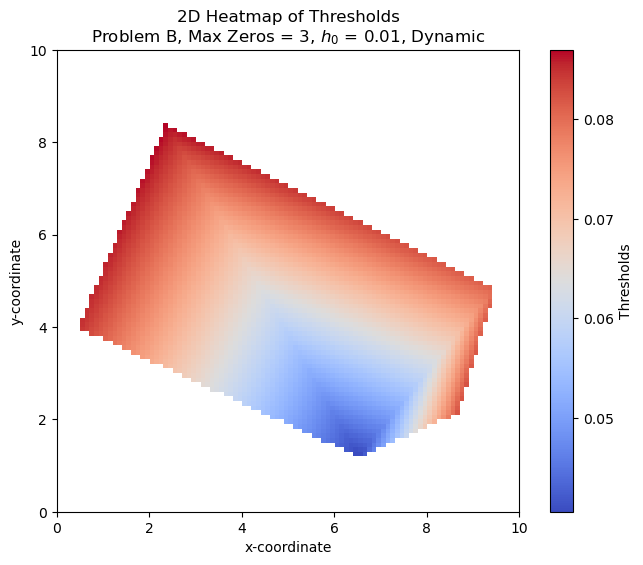

In [27]:
# Data
x = [obs[0] for obs in sampleofICs]
y = [obs[1] for obs in sampleofICs]
z = [obs[1] for obs in data]

# Define grid
grid_x,grid_y = np.meshgrid(np.linspace(0,10,100),np.linspace(0,10,100))

# Interpolate values onto the grid
grid_values = griddata((x,y),z,(grid_x,grid_y),method='linear')

# Plot heatmap
plt.figure(figsize=(8,6))
plt.imshow(grid_values,extent=(0,10,0,10),origin='lower',cmap='coolwarm')
plt.colorbar(label='Thresholds')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
s_wth = f"2D Heatmap of Thresholds\n{s_problem}"
print(s_wth)
plt.title(s_wth)
plt.show()

## Bisection Method

In [5]:
# Define the bisection function

def bisection(f,a,b,x,default_error,epsilon=0.0001):
  fa = f(x,a,max_error)
  fb = f(x,b,max_error)
  #print(f"fa {fa}, {a}")
  #print(f"fb {fb}, {b}")
  # assumes f(a) and f(b) bracket the best value / root # but it doesnt!
  while (b-a)/2. > epsilon:
    c = (a+b)/2.
    fc = f(x,c,default_error)
    #print(f"fc {fc}, {c}")
    if fc == 0:
      break
    elif fa*fc < 0:
      b = c
      # fb = f(b)
    else:
      a = c
      fa = fc
  return c


In [10]:
z = lambda x,threshold,default_error: default_error - error_function(x,threshold)

default_error = 2.005
# h_initial = 

data = []

for x in sampleofICs: # "initial condition" ~ entire sample of data
  h0 = 1.8 # h_initial*.9
  h1 = 2.0 #h_initial*1.1
  h = bisection(z,h0,h1,x,default_error,epsilon=0.0001)
  print(f"x: [{x}], h: {h} z={z(x,default_error)}")
  
  data.append(h)

x: [[6.535895854646095, 1.1500694312440574]], h: 1.9998046875 z=1.9999895344547776
x: [[9.502828643490245, 4.821914014279982]], h: 1.9998046875 z=1.9999964066233642
x: [[8.724745351820353, 2.1233268092271995]], h: 1.9998046875 z=1.9999908469400411
x: [[0.40709624769089126, 3.971944613457058]], h: 1.9998046875 z=1.9999877354789737
x: [[2.3313219734837998, 8.417407242530615]], h: 1.9998046875 z=1.9999900770883345
x: [[2.070823443867469, 7.424695335824087]], h: 1.9998046875 z=1.999990113580571
x: [[3.921541278088413, 1.8225651995238434]], h: 1.9998046875 z=1.9999956030589057
x: [[7.4353941459214, 0.6958208096995455]], h: 1.9998046875 z=1.9999882920871792
x: [[8.853372043807507, 9.526443992215418]], h: 1.9998046875 z=1.9999997427506642
x: [[9.311434346775108, 4.154309530449078]], h: 1.9998046875 z=1.9999952319895584
x: [[0.2898165938687125, 9.820274845981977]], h: 1.9998046875 z=1.999987507307757
x: [[3.3963768363528857, 7.066871938888038]], h: 1.9998046875 z=1.9999942587957218
x: [[3.6187

###### display output in various ways


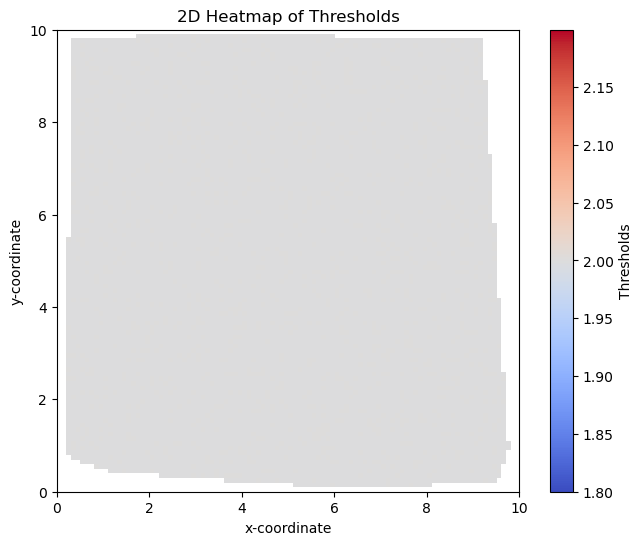

In [11]:
# Data
x = [obs[0] for obs in sampleofICs]
y = [obs[1] for obs in sampleofICs]
z = data

# Define grid
grid_x,grid_y = np.meshgrid(np.linspace(0,10,100),np.linspace(0,10,100))

# Interpolate values onto the grid
grid_values = griddata((x,y),z,(grid_x,grid_y),method='linear')

# Plot heatmap
plt.figure(figsize=(8,6))
plt.imshow(grid_values,extent=(0,10,0,10),origin='lower',cmap='coolwarm')
plt.colorbar(label='Thresholds')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('2D Heatmap of Thresholds')
plt.show()


In [38]:
z = lambda x,threshold,default_error: error_function(x,threshold) - default_error

default_error = 0
# h_initial = 

data = []

for x in sampleofICs: # "initial condition" ~ entire sample of data
  h0 = 0.1 # h_initial*.9
  h1 = 1 #h_initial*1.1
  h = bisection(z,h0,h1,x,default_error,epsilon=0.001)
  print(f"x: [{x}], h: {h} z={z(x,h,default_error)}")
  data.append(h)


x: [[6.535895854646095, 1.1500694312440574]], h: 0.9982421875 z=0.005
x: [[9.502828643490245, 4.821914014279982]], h: 0.9982421875 z=0.005
x: [[8.724745351820353, 2.1233268092271995]], h: 0.9982421875 z=0.005
x: [[0.40709624769089126, 3.971944613457058]], h: 0.9982421875 z=0.005
x: [[2.3313219734837998, 8.417407242530615]], h: 0.9982421875 z=0.005
x: [[2.070823443867469, 7.424695335824087]], h: 0.9982421875 z=0.005
x: [[3.921541278088413, 1.8225651995238434]], h: 0.9982421875 z=0.005
x: [[7.4353941459214, 0.6958208096995455]], h: 0.9982421875 z=0.005
x: [[8.853372043807507, 9.526443992215418]], h: 0.9982421875 z=0.005
x: [[9.311434346775108, 4.154309530449078]], h: 0.9982421875 z=0.005
x: [[0.2898165938687125, 9.820274845981977]], h: 0.9982421875 z=0.005
x: [[3.3963768363528857, 7.066871938888038]], h: 0.9982421875 z=0.005
x: [[3.6187706760756178, 0.3510589795136143]], h: 0.9982421875 z=0.005
x: [[8.55058253240408, 6.572535081404924]], h: 0.9982421875 z=0.005
x: [[7.656829941452386, 5.

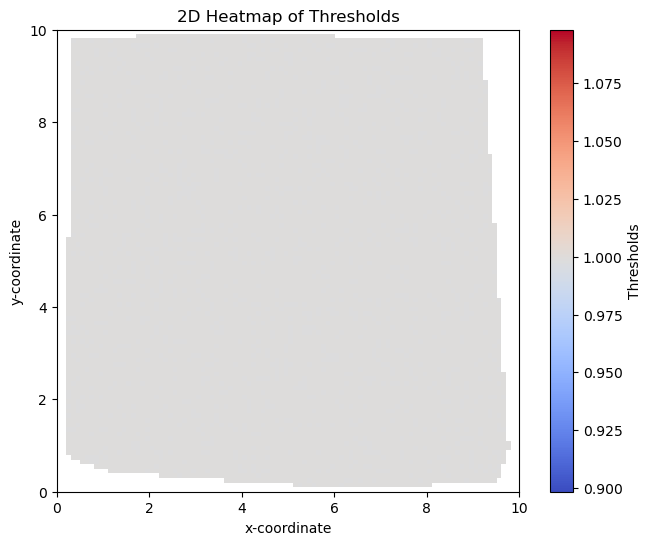

In [39]:
# Data
x = [obs[0] for obs in sampleofICs]
y = [obs[1] for obs in sampleofICs]
z = data

# Define grid
grid_x,grid_y = np.meshgrid(np.linspace(0,10,100),np.linspace(0,10,100))

# Interpolate values onto the grid
grid_values = griddata((x,y),z,(grid_x,grid_y),method='linear')

# Plot heatmap
plt.figure(figsize=(8,6))
plt.imshow(grid_values,extent=(0,10,0,10),origin='lower',cmap='coolwarm')
plt.colorbar(label='Thresholds')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('2D Heatmap of Thresholds')
plt.show()
